# Predicting Why Employees Leave
According to the [Bureau of Labor Statistics](http://www.bls.gov/news.release/tenure.nr0.htm) the median number of years that wage and salary workers had been with their current employer was 4.2 years in January 2016. While this number varies from industry to industry the story of an employee who sticks with one company for the entirety of a working life seems to be rather antiquated. 
Now more than ever it gets important to acquire the necessary tools for employers to understand where its workforce is standing. Additional insights from employer reports, scorecards as well as general statistical information can offer prediction values for companies when it comes to the longetivity of jobs. In this notebook we are trying to predict the likelihood of an employee quitting based on available information.

## Dataset
This dataset was taken from [kaggle](https://www.kaggle.com/ludobenistant/hr-analytics). In the next few paragraphs we'll be exploring key information and features available in the dataset.

## Exploration

In [8]:
# Read in data
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
%matplotlib inline
from collections import Counter
plot_color = 'crimson'


hr_data = pd.read_csv('data/HR_comma_sep.csv', header=0)

In [9]:
hr_data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [10]:
print "The data set has {} data points and {} variables.".format(*hr_data.shape)

The data set has 14999 data points and 10 variables.


In [11]:
# Check if there are any NaN values
for name, item in hr_data.isnull().sum().iteritems():
    if item > 0:
        print name

In [12]:
# Describe categorical data
print "hr_data['sales']:", hr_data['sales'].unique(), '\n'
print "hr_data['salary']:", hr_data['salary'].unique()
# Rename column to fit better, get rid of typos and instill consistency
hr_data = hr_data.rename(
    columns = {'sales' : 'department', 
               'average_montly_hours' : 'average_monthly_hours',
               'Work_accident' : 'work_accident'})

hr_data['sales']: ['sales' 'accounting' 'hr' 'technical' 'support' 'management' 'IT'
 'product_mng' 'marketing' 'RandD'] 

hr_data['salary']: ['low' 'medium' 'high']


In [13]:
hr_data.describe()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


The data set has no NaN values. Since there is no additional information regarding the data set we are starting with some assumptions about the variables based on their description.

* **satisfaction_level:** 1 most likely indicating a high satisfaction level [value in the range of 0 and 1]
* **last_evaluation:** Most likely the rating of given employee [numeric value between 0 and 1]
* **number_project:** The amount of projects an employee has. [numeric value between 2 and 7]
* **average_monthly_hours:** The hours an employee works per month [numeric value between 96 and 310]
* **time_spend_company:** Given current working statistics we are most likely dealing with years. [numeric value between 2 and 10]
* **work_accident:** Numeric expression of boolean value whether an employee had a work accident [1 = true, 0 = false]
* **left:** Label if person left or not [1 = true, 0 false]
* **promotion_last_5years:** Numeric expression of boolean value whether and employee was promoted within the last 5 years [1 = true, 0 = false]
* **department:** Categorical variable describing the position of an employee. [sales, accounting, hr, technical, support, management, IT, product_mng, marketing, RanD]
* **salary:** Categorical variable indicating salary level of employee. [low, medium, high]

### First Questions
* How many people left their company?
* What's the average tenure?
* What's the salary structure?
* Which department works the most hours?
* Where do most work accidents appear?
* What is the satisfaction level by department?

### How many people left their company
Let's see how the distribution of our indipendent variable looks like. It's important to note that we'll need a similar distribution of this variable for our training and testing sets.

In [14]:
people_left = len(hr_data[hr_data['left'] == 1])
print "{} Persons left their company ({:.3} %)".format(
    people_left, (people_left/float(len(hr_data))))

3571 Persons left their company (0.238 %)


In order to decide whether to pick the mean or median values for comparison, we'll be computing the variance of each option.

In [15]:
# Mean or median
mean_by_dept = hr_data.groupby('department').mean()
median_by_dept = hr_data.groupby('department').median()

mm_comp = []
index = []
for row_mean, row_median in zip(mean_by_dept.var().iteritems(), median_by_dept.var().iteritems()):
    mm_comp.append([row_mean[1], row_median[1]])
    index.append(row_mean[0])

mm_comp = pd.DataFrame(mm_comp, columns=['mean', 'median'], index=index)
mm_comp

,mean,median
satisfaction_level,0.000157,0.000291
last_evaluation,0.000028,0.000143
number_project,0.005299,0.000000
average_monthly_hours,1.376778,4.011111
time_spend_company,0.077200,0.000000
work_accident,0.000276,0.000000
left,0.002177,0.000000
promotion_last_5years,0.001051,0.000000


There is clearly more information gain from the mean values, which also indicates that we're not dealing with too many outliers in our data set. We'll be continuing using mean values for our department by department analysis.

### What's the average tenure over all departments

In [16]:
# Average tenure
print "Average tenure: {:.4}".format(hr_data['time_spend_company'].mean())

Average tenure: 3.498


It shows that people in our data set tend to leave the company earlier than the average depicted in the first paragraph. Which could indicate that the population we're looking at is either younger than the average work force or, more likely, that we're not representing state and federal employees which tend to have a way higher tenure (> 8 years).

### What do key predictors look like by department
In order to get a better grasp on the information that is contained in the data set, we'll be looking at the predictors through the eyes of each department.

In [17]:
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.layouts import gridplot
from bokeh.layouts import column, row
from bokeh.plotting import reset_output
from bokeh.charts.attributes import cat

row_coll = []
rows = []
counter = 1

for column in mean_by_dept.columns:
    column_title_split = column.split('_')
    column_title = ""
    for column_title_piece in column_title_split:
        column_title += " " +column_title_piece.title()
    
    p = Bar(mean_by_dept, 
            values=column, 
            title=column_title + ' by department',
            color=plot_color,
            plot_width=300, 
            plot_height=200,
            ylabel="",
            legend=None,
            toolbar_location=None)
    rows.append(p)
    if len(rows) == 3:
        row_coll.append(list(rows))
        reset_output()
        rows = []
    
row_coll.append(list(rows))
    
#print row_coll
gridplot = gridplot(row_coll, toolbar_location=None)
output_notebook()
show(gridplot)

Loading BokehJS ...

#### Insights by department
* The satisfaction level seems to be quite consistant over all departments. Only **accountants** & **HR** have a slight below average satisfaction level.
* Evaluation levels are on a consistant level over all departments.
* **HR** & **Marketing** seem to have slightly below average number of projects.
* All departments seem to clock in the same amount of time on a monthly basis. Guess there are only so much hours to the week. 
* **Management** is the clear frontrunner, when it comes to tenure. This makes sense, since a management position comes with greater responsibility & lock-in effects.
* **R&D**, **Management**, **Marketing** & **Support** seem to have the most hazardous work environment. With **Accounting** & **HR** being on the safety first side.
* **Management** & **R&D** have the highest average loyalty rate. **Accounting** & **HR** on the other hand are fluctuating quite a bit.
* **Management** have by far the highest promotion rate. In **Marketing** almost one out of two has had a promotion within the last 5 years, in the **R&D** department over 30 % has advanced on a professional level in the last 5 years. The **Support** and **Technical** departments are on the lowest spectrum.

In [18]:
mean_by_dept

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years
department,,,,,,,,
IT,0.618142,0.716830,3.816626,202.215974,3.468623,0.133659,0.222494,0.002445
RandD,0.619822,0.712122,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307
accounting,0.582151,0.717718,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253
hr,0.598809,0.708850,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298
management,0.621349,0.724000,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524
marketing,0.618601,0.715886,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117
product_mng,0.619634,0.714756,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000
sales,0.614447,0.709717,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155
support,0.618300,0.723109,3.803948,200.758188,3.393001,0.154778,0.248991,0.008973


In [19]:
pdf = pd.DataFrame.from_dict(Counter(hr_data['salary']), orient='index')
pdf.columns = ['Salary']

p = Bar(pdf,
        values='Salary',
        title='Salary',
        color=plot_color,
        plot_width=800, 
        plot_height=300,
        ylabel="Counts",
        legend=None,
        toolbar_location=None)

show(p)

In [20]:
pdf1 = pd.DataFrame.from_dict(Counter(hr_data['department']), orient='index')
pdf1['Department'] = pdf1.index
pdf1.columns =['Counts', 'Department']

pdf1.sort_values(by='Counts', inplace=True, ascending=False)
#pdf1 = pdf1.reset_index(drop=True)

p = Bar(pdf1,
        values='Counts',
        label=cat(columns='Department', sort=False),
        title='Counts',
        color=plot_color,
        plot_width=800, 
        plot_height=300,
        ylabel="Counts",
        legend=None,
        toolbar_location=None)
show(p)

pdf1

,Counts,Department
sales,4140,sales
technical,2720,technical
support,2229,support
IT,1227,IT
product_mng,902,product_mng
marketing,858,marketing
RandD,787,RandD
accounting,767,accounting
hr,739,hr
management,630,management


## Data preparation
Make data machine readable. One-hot-encoding for categorical cases.

In [46]:
def preprocess_features(X):
    ''' 
    Preprocesses input data. 
    converts non-numeric binary variables into
    binary (0/1) variables. 
    Converts categorical variables into dummy variables. 
    '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

hr_data_corr = preprocess_features(hr_data)

print "Processed feature columns ({} total features):\n{}".format(
    len(hr_data_corr.columns), list(hr_data_corr.columns))

Processed feature columns (21 total features):
['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'work_accident', 'left', 'promotion_last_5years', 'department_IT', 'department_RandD', 'department_accounting', 'department_hr', 'department_management', 'department_marketing', 'department_product_mng', 'department_sales', 'department_support', 'department_technical', 'salary_high', 'salary_low', 'salary_medium']


## Regression & Correlation 

After encoding and preprocessing the data set we're curious in how the variables work with each other. This might be especially insightful when deciding which features to include or exclude. This is an important step to understanding what measures might be helpful when trying to prevent a high leaving rate.

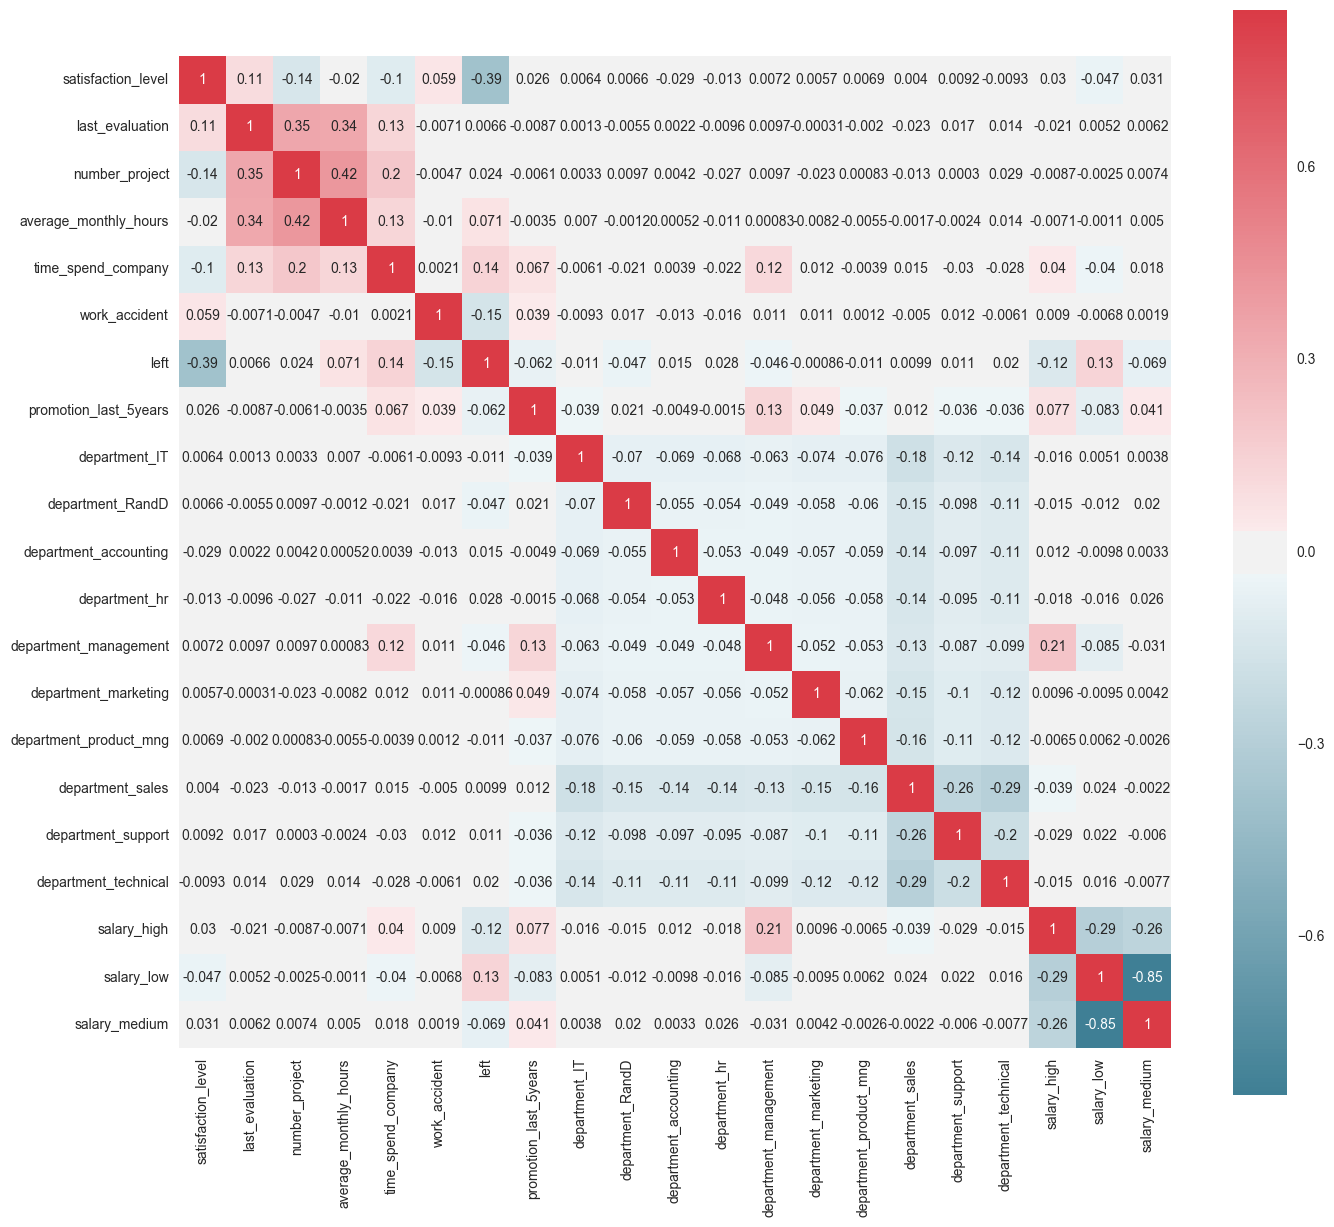

In [15]:
plt.figure(figsize=(16, 14))
cmap = sns.diverging_palette(222, 10, as_cmap=True)
_ = sns.heatmap(hr_data_corr.corr(), annot=True, vmax=.8, square=True, cmap=cmap)

Just based on the heatmap there are already a couple of interesting observations one can make.

* A high satistfaction level seems to lead to a lower leaving rate.
* Employees with higher salary are less inclined to leave.
* On the other hand low salary employees seem to leave the company more often. 
* There's a positive correlation between the time a person spends at a company and the fact if they left.

But in order to get more granular we are interested in the highly correlated (strength > .1) and highly significant (p-Value > 0.05) connections.

In [22]:
def corr_table(data, features, sig_level=0.05, strength=0.0):
    import math
    import numpy as np
    from scipy.stats import pearsonr

    from operator import itemgetter
    p_val_dict = []
    check_dict = []
    for feature in features:
        feature_first = feature.split('_')[0]
        for label in features:
            # Since these correlations go in both directions, we only need to store on 
            # of the correlations and can discard the secon one
            # i.e. corr(age, Medu) has equal insights to corr(Medu, age)
            feature_comb = label+feature
            label_first = label.split('_')[0]
            
            if feature == label or feature_comb in check_dict or feature_first == label_first:
                #feature is already paired with label or equals label
                #or feature and label are from the same one-hot-encoding category
                continue
            else:
                check_dict.append(feature+label)
                pears = pearsonr(data[feature], data[label])
                p_val = pears[1]
                corr_strength = pears[0]
                cov_strength = np.cov(data[feature], data[label])[0][1]
                
                # Check if correlation is significant and has a high enough correlation
                if p_val < sig_level and math.fabs(corr_strength) > strength:
                    p_val_dict.append([feature, label, cov_strength, corr_strength, p_val])

    p_corr_title = 'Correlation > ' + str(strength)
    p_value_title = 'p-Value < ' + str(sig_level)
    p_val_dict = pd.DataFrame(p_val_dict, columns = ['Feature', 'Label', 'Covariance', p_corr_title, p_value_title])
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    
    p_val_dict['order'] = abs(p_val_dict[p_corr_title])
    p_val_dict.sort_values(by='order', inplace=True, ascending=False)
    p_val_dict.head()
    p_val_dict = p_val_dict.reset_index(drop=True)
    p_val_dict = p_val_dict.drop('order', axis=1)
    
    return p_val_dict



In [23]:
reg_features = hr_data_corr.columns[~hr_data_corr.columns.str.contains('left')]
label = reg_features

# How many significant correlations are in the data set?
correlations_all = corr_table(hr_data_corr, reg_features, strength=0.1)

In [24]:
correlations_all

,Feature,Label,Covariance,Correlation > 0.1,p-Value < 0.05
0,number_project,average_monthly_hours,25.6833,0.4172,0.0000
1,last_evaluation,number_project,0.0737,0.3493,0.0000
2,last_evaluation,average_monthly_hours,2.9044,0.3397,0.0000
3,department_management,salary_high,0.0115,0.2091,0.0000
4,number_project,time_spend_company,0.3542,0.1968,0.0000
5,satisfaction_level,number_project,-0.0438,-0.1430,0.0000
6,last_evaluation,time_spend_company,0.0329,0.1316,0.0000
7,promotion_last_5years,department_management,0.0037,0.1281,0.0000
8,average_monthly_hours,time_spend_company,9.3164,0.1278,0.0000
9,time_spend_company,department_management,0.0338,0.1154,0.0000


Based on our correlation analysis we can infer the following observations:
* Employees with a higher number of project tend to have a significant higher work load per month.
* A high evaluation level leads to an increase in the amount of projects (and therefore an increased monthly workload)
* People from the management department tend to have a higher salary
* An increase of number of project tends to a higher tenure rate.
* A low number of projects has a negative correlation with the satisfaction level.
* If the last evaluation was higher, the person was more likely to stay.
* As mentioned above, people from the management department tend to have a higher promotion rate.
* A high effort, measured by an average monthly hours, leads to a significant higher retention rate.
* People in management jobs have a higher tenure.
* A high last evaluation has a positive impact on the satisfaction level.
* A low satisfaction level has a negative correlation with the time an employee stays at a company.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the employee features present in the data. If we found that the feature you attempted to predict above is relevant for identifying a specific employee, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific employee, the scatter matrix might show a correlation between that feature and another feature in the data.

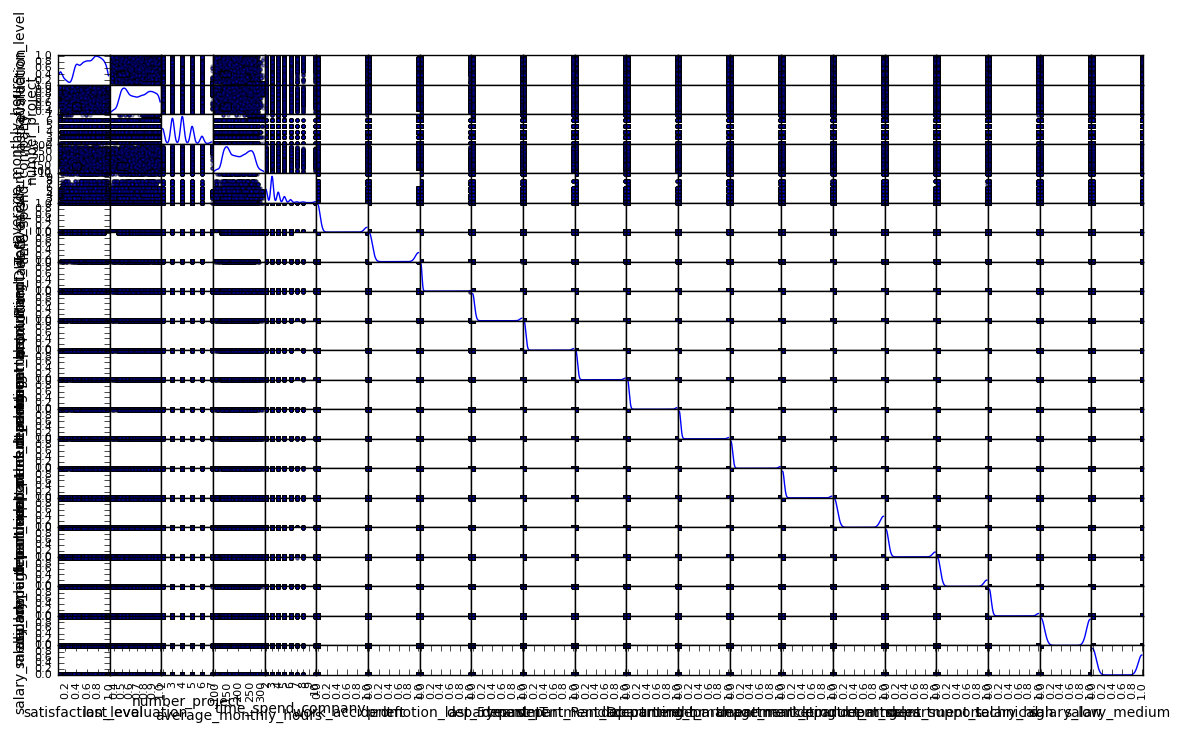

In [40]:
# Next we'll implement unsupervised learning to cluster employees into categories and see where this will lead us
pd.scatter_matrix(hr_data_corr[], alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [49]:

# Unsupervised learning, to cluster employees into categories
import numpy as np
#log_data = np.log(hr_data_corr.copy())
#np.log(hr_data_corr)
# Problem: /Users/andirs/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: 
#   RuntimeWarning: divide by zero encountered in log

## Prediction
Let's move forward with the prediction process. After making all features machine readable we'll need to determine a model to use for our purposes. Because we want to find out, whether an employee left the company or is still employed, we'll approach this problem-set as a classification issue. 

Since we're dealing with a low-mid-range amount of labeled data (below 100K data points) we'll start the prediction task with a Linear Support Vector Machine. There are more sophisticated machine learning algorithm we can lean on but it's always a good idea to start at the bottom and work your way up. The second model we're looking into is a Decision Tree Classifier, because of its simplicity and computational efficiency. As a third contender we'll try implementing a more sophisticated Support Vector Machine that leverages additional dimensions through an rbf kernel and last but not least we'll be predicting through a Random Forest Classifier. Last but not least an eXtreme Gradient Boosting Algorithm is implemented.

Since sklearn makes it quite easy to add additional estimators as we go we'll go ahead and implement training and cross validation once and start looping over the process with our different models. eXtreme Gradient Boosting will be implemented seperately. 

### Setup
The prediction process will be as follows:
1. We'll split our correlation data set with all machine readable information into a training and a testing set. We'll leave out 40 % of the original datapints for testing purposes to validate our final model. In this step we'll make sure to use the stratify option while splitting in order to keep a similar distribution of label data in testing and training set.
2. The training features set will be split into independent (predictors) and dependent (label) variables. The predictors will be used to predict the label.
3. A random state will be set which will help with the reproducibility of the prediction process. (Note: Not all estimator implementations might have the option to seed a random state)
4. In order to avoid overfitting we'll perform k-fold cross-validation with k = 5. This means we'll split our training set in 5 separate buckets, use 4 of these buckets to train and the left out bucket for testing. CV performs this k-times. The average score will give a better indicator on how the model will perform on our testing set.

In [50]:
# Let's start the prediction
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn import cross_validation
from time import time

# Let's keep 40 % of the data for testing purposes
test_size = .4
random_state = 42

X_all = hr_data_corr.drop('left', 1)
y_all = hr_data_corr['left']

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    X_all, y_all, test_size = test_size, random_state = random_state, stratify=y_all)

clf_report = []
clf_feature_relevance = []

for clf in [LinearSVC(random_state = random_state),
            LogisticRegression(random_state = random_state),
            DecisionTreeClassifier(random_state = random_state),
            SVC(random_state = random_state),
            RandomForestClassifier(random_state = random_state)]:
    # Extract name of estimator
    clf_name = clf.__class__.__name__
    print "Training", clf_name, "..."
    # Fit model on training data
    clf.fit(X_train, y_train)
    # Predict based on it
    # y_pred = clf.predict(X_train)
    
    # Perform cross validation
    start = time()
    scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5) 
    end = time()
    duration = end - start
    print "Average CV performance for {}: {:.6} (in {:.6} seconds)".format(clf_name, scores.mean(), duration)
    clf_report.append([clf_name, scores.mean(), duration])

    # Store feature relevance information 
    if clf_name in ["RandomForestClassifier", "DecisionTreeClassifier"]:
        clf_feature_relevance.append(clf.feature_importances_.tolist())
    elif clf_name == "LinearSVC":
        clf_feature_relevance.append(clf.coef_[0].tolist())
# Store information in list for better visibility

clf_report = pd.DataFrame(clf_report, columns=['classifier', 'mean_score', 'time'])

Training LinearSVC ...
Average CV performance for LinearSVC: 0.714595 (in 2.33232 seconds)
Training LogisticRegression ...
Average CV performance for LogisticRegression: 0.795644 (in 0.168637 seconds)
Training DecisionTreeClassifier ...
Average CV performance for DecisionTreeClassifier: 0.971331 (in 0.163079 seconds)
Training SVC ...
Average CV performance for SVC: 0.943326 (in 5.38795 seconds)
Training RandomForestClassifier ...
Average CV performance for RandomForestClassifier: 0.983331 (in 0.425176 seconds)


In [26]:
import xgboost

In [27]:
print clf.get_params

<bound method RandomForestClassifier.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)>


In [28]:
pd.DataFrame(clf_feature_relevance, columns=X_train.columns, index=['LinearSVC', 
                                                                    'DecisionTreeClassifier', 
                                                                    'RandomForestClassifier'])

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
LinearSVC,-1.6691,-0.3870,-0.2414,0.0078,0.0433,-0.4891,-0.1972,-0.0157,-0.1383,0.0995,0.1754,-0.0362,0.1656,0.0214,0.0721,0.0864,0.0846,-0.1359,0.4202,0.2303
DecisionTreeClassifier,0.5106,0.1459,0.1039,0.0769,0.1368,0.0025,0.0002,0.0019,0.0004,0.0017,0.0008,0.0006,0.0007,0.0000,0.0016,0.0030,0.0035,0.0014,0.0063,0.0013
RandomForestClassifier,0.3130,0.1188,0.1589,0.1424,0.2189,0.0103,0.0008,0.0017,0.0016,0.0015,0.0020,0.0011,0.0012,0.0015,0.0035,0.0031,0.0038,0.0038,0.0086,0.0036


In [22]:
clf_report.sort_values(by=['mean_score', 'time'], ascending=False)

,classifier,mean_score,time
3,RandomForestClassifier,0.9833,1.6177
1,DecisionTreeClassifier,0.9713,0.1704
2,SVC,0.9433,11.0103
0,LinearSVC,0.7146,2.2874


In [30]:
scores = cross_validation.cross_val_score(clf, X_train, y_train, cv=5) 

In [31]:
scores.mean()

0.98333147866883763

In [32]:
predictor_list = []
for relevance in clf.feature_importances_:
    predictor_list.append(relevance)
new = pd.DataFrame(predictor_list, columns=['importance'], index=X_all.columns.values.tolist())
new.sort_values(by='importance', ascending=False, inplace=True)
new['features'] = new.index

p = Bar(new,
        values='importance',
        label=cat(columns='features', sort=False),
        title='Feature importance',
        color='crimson',
        plot_width=800, 
        plot_height=500,
        ylabel='importance',
        legend=None,
        toolbar_location=None)
show(p)

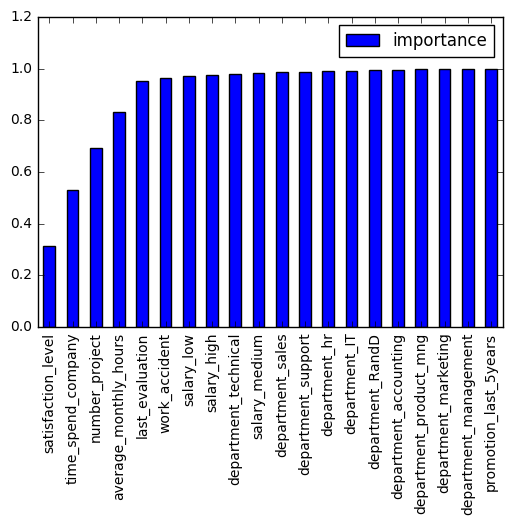

In [33]:
new.cumsum().plot(kind='bar')

In [38]:
# New features
# underpaid (high working hours, low salary)

